In [33]:
!pip install torchmetrics -q

In [34]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics
from torch.utils.data import Dataset, DataLoader

In [8]:
"""
The fashion MNIST dataset is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples.
Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement 
of the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark
to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said.
"Well, if it does work on MNIST, it may still fail on others."
Zalando seeks to replace the original MNIST dataset 
"""

'\nThe fashion MNIST dataset is a dataset of Zalando\'s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples.\nEach example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement \nof the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.\nThe original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark\nto validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn\'t work on MNIST, it won\'t work at all", they said.\n"Well, if it does work on MNIST, it may still fail on others."\nZalando seeks to replace the original MNIST dataset \n'

In [4]:
# downlaod data
training = torchvision.datasets.FashionMNIST(root = "./data", 
                                             train = True, 
                                             download = True, 
                                             transform = torchvision.transforms.ToTensor())

testing = torchvision.datasets.FashionMNIST(root = "./data", 
                                            train = False, 
                                            download = True, 
                                            transform = torchvision.transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [21]:
# check data
print("Training Data: ", training, '\n')
print("Testing Data: ", testing)

Training Data:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor() 

Testing Data:  Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


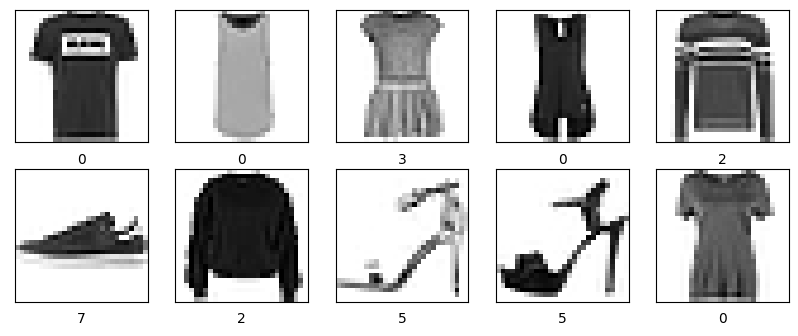

In [19]:
# print few images to see what they look like
import matplotlib.pyplot as plt
import numpy as np

# plot 10 images with labels
figure = plt.figure(figsize = (10, 10))
for i in range(1, 11):
    plt.subplot(5, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training[i][0].squeeze(), cmap = plt.cm.binary)
    plt.xlabel(training[i][1])

In [20]:
# create data loaders
train_loader = DataLoader(training, 
                          batch_size = 64, 
                          shuffle = True, 
                          num_workers = 4)

test_loader = DataLoader(testing, 
                         batch_size = 64, 
                         shuffle = True, 
                         num_workers = 4)

# check dataloaders dimensions
print(len(train_loader))
print(len(test_loader))

938
157


In [22]:
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
# create a model
class FashionMNIST(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.big_layer = nn.Sequential(nn.Flatten(),
                                       nn.Linear(input_size, 128),
                                       nn.ReLU(),
                                       nn.Linear(128, 64),
                                       nn.ReLU(),
                                       nn.Linear(64, output_size),
        )

    def forward(self, x):
        return self.big_layer(x)
    
# create model instance
model = FashionMNIST(784, 10).to(device) # 784 is the size of the image, 10 is the number of classes

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01)

# Accuracy function from torchmetrics
accuracy = torchmetrics.Accuracy(task = "multiclass",
                                 num_classes = 10,
).to(device)
                                 


In [24]:
# check model
print(model)

FashionMNIST(
  (big_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [66]:
from tqdm.auto import tqdm # for progress bar

# def training function
def train(model, train_loader, optimizer, loss_fn, accuracy_fn):
    accuracy = accuracy_fn

    # total loss and accuaracy
    train_loss = 0
    train_acc = 0

    print(f"Epoch: {epoch} --------------------------")
    for batch, (x, y) in enumerate(train_loader):
        # reset accuaracy
        accuracy.reset()
        x, y = x.to(device), y.to(device)

        # forward pass
        y_pred = model(x)

        # calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # calculate accuracy
        acc = accuracy(y_pred, y)
        train_acc += acc

        # zero grad
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # gradient descent
        optimizer.step()

    # get total loss and accuaracy
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # print loss and accuracy
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")


def test(model, test_loader, loss_fn, accuracy_fn):
    # total loss and accuaracy
    test_loss, test_acc = 0, 0
    accuracy = accuracy_fn

    # test model
    model.eval()
    with torch.inference_mode():
        for batch, (x_test, y_test) in enumerate(test_loader):
            x_test, y_test = x_test.to(device), y_test.to(device)

            # forward pass
            y_pred_test = model(x_test)

            # calculate loss
            test_loss += loss_fn(y_pred_test, y_test)

            # calculate accuracy
            test_acc += accuracy(y_pred_test, y_test)

        # get total loss and accuaracy
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    # print loss and accuracy
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


In [68]:
# train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    train(model, train_loader, optimizer, loss_fn, accuracy)
    test(model, test_loader, loss_fn, accuracy)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 --------------------------
Train Loss: 0.2481 | Train Accuracy: 0.9135
Test Loss: 0.4778 | Test Accuracy: 0.8618
Epoch: 1 --------------------------
Train Loss: 0.2436 | Train Accuracy: 0.9145
Test Loss: 0.5113 | Test Accuracy: 0.8639
Epoch: 2 --------------------------
Train Loss: 0.2414 | Train Accuracy: 0.9150
Test Loss: 0.4947 | Test Accuracy: 0.8639
Epoch: 3 --------------------------
Train Loss: 0.2450 | Train Accuracy: 0.9165
Test Loss: 0.5129 | Test Accuracy: 0.8717
Epoch: 4 --------------------------
Train Loss: 0.2414 | Train Accuracy: 0.9156
Test Loss: 0.5151 | Test Accuracy: 0.8736
Epoch: 5 --------------------------
Train Loss: 0.2467 | Train Accuracy: 0.9134
Test Loss: 0.5814 | Test Accuracy: 0.8671
Epoch: 6 --------------------------
Train Loss: 0.2499 | Train Accuracy: 0.9135
Test Loss: 0.5148 | Test Accuracy: 0.8728
Epoch: 7 --------------------------
Train Loss: 0.2374 | Train Accuracy: 0.9159
Test Loss: 0.5207 | Test Accuracy: 0.8729
Epoch: 8 ---------------